In [8]:
from siuba import *
from plotnine import *
from calitp.tables import tbl
from siuba.sql import LazyTbl
from siuba.sql import sql_raw
from siuba.experimental import completer

## Are often do feeds lack a feed_end_date?

In [38]:
tbl_daily_feed = (
    tbl.views.gtfs_schedule_fact_daily_feeds()
    >> mutate
    (missing_date = _
    >>count(_.date)
)

In [52]:
tbl_daily_feeds_enriched = (tbl.views.gtfs_schedule_fact_daily_feeds()
  >> inner_join(_, tbl.views.gtfs_schedule_dim_feeds(), "feed_key")
)

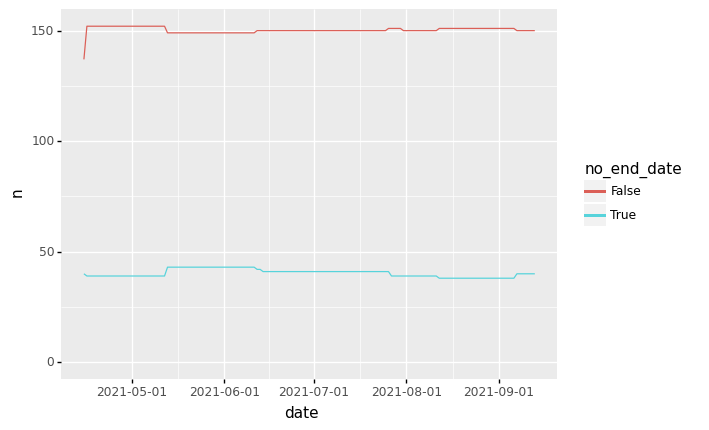

<ggplot: (8778778965712)>

In [50]:
(tbl.views.gtfs_schedule_fact_daily_feeds()
  >> inner_join(_, tbl.views.gtfs_schedule_dim_feeds(), "feed_key")
  >> count(_.date, no_end_date = _.feed_end_date.isna())
  >> collect()
  >> mutate(date = _.date.astype("datetime64[ns]"))
  >> ggplot(aes("date", "n", color = "no_end_date")) + geom_line() + expand_limits(y = 0)

)

In [53]:
tbl.views.gtfs_schedule_fact_daily_service()

,feed_key,calitp_itp_id,calitp_url_number,service_date,service_id,ttl_service_hours,n_trips,n_routes,first_departure_ts,last_arrival_ts,service_window
0,-1830378221579909888,346,0,2021-04-21,c_15968_b_17398_d_31,147.333333,137,10,18900,102600,23.25
1,-1830378221579909888,346,0,2021-04-19,c_15968_b_17398_d_31,147.333333,137,10,18900,102600,23.25
2,-1830378221579909888,346,0,2021-04-27,c_15968_b_17398_d_31,147.333333,137,10,18900,102600,23.25
3,-1830378221579909888,346,0,2021-04-22,c_15968_b_17398_d_31,147.333333,137,10,18900,102600,23.25
4,-1830378221579909888,346,0,2021-04-16,c_15968_b_17398_d_31,147.333333,137,10,18900,102600,23.25


In [51]:
# get type 2 calendar data (cal across history)
(
    tbl.gtfs_schedule_type2.calendar_clean()
    # expand it for each day
    inner_join(_, tbl_daily_feeds_enriched

    # group by feed and date, summarize with max calendar end date
)

,calitp_itp_id,calitp_url_number,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,calitp_extracted_at,calitp_hash,start_date,end_date,calendar_key,calitp_deleted_at
0,135,0,c_20840_b_28431_d_31,1,1,1,1,1,0,0,2021-08-25,hBufcx5lQ8RNqM+NrXAdBQ==,2021-03-08,2022-07-01,7202703122571340765,2099-01-01
1,108,0,c_20840_b_28431_d_31,1,1,1,1,1,0,0,2021-06-24,x1gmMP/RJzVdlla/2+oLyw==,2021-03-08,2022-07-01,-8369198626424417814,2021-08-23
2,108,0,c_20840_b_28431_d_31,1,1,1,1,1,0,0,2021-08-25,x1gmMP/RJzVdlla/2+oLyw==,2021-03-08,2022-07-01,-6278681314966852680,2099-01-01
3,42,0,c_20840_b_28431_d_31,1,1,1,1,1,0,0,2021-06-24,EsFVwe0EgCBInCVym8/grg==,2021-03-08,2022-07-01,7370780306301070330,2021-08-23
4,135,0,c_20840_b_28431_d_31,1,1,1,1,1,0,0,2021-04-15,szQxsCnfDI4fBEcueAiC4w==,2021-03-08,2021-06-30,-3217614124353620103,2021-06-15


# Calculate MAX service end date per date, feed_key from views.gtfs_schedule_fact_daily_service_trips

In [56]:
tbl_feeds_service = (
    tbl.views.gtfs_schedule_fact_daily_service()
    >>group_by(_.calitp_itp_id, _.calitp_url_number)
    >>mutate(
        max_service_date = (_.service_date.max())
    )
)

In [57]:
tbl_feeds_service

,feed_key,calitp_itp_id,calitp_url_number,service_date,service_id,ttl_service_hours,n_trips,n_routes,first_departure_ts,last_arrival_ts,service_window,max_service_date
0,-7640288827286773086,1,2,2021-05-04,72801,12.816667,16,1,15000,69900,15.25,2021-05-12
1,-7640288827286773086,1,2,2021-04-27,72801,12.816667,16,1,15000,69900,15.25,2021-05-12
2,-7640288827286773086,1,2,2021-04-26,72801,12.816667,16,1,15000,69900,15.25,2021-05-12
3,-7640288827286773086,1,2,2021-04-20,72801,12.816667,16,1,15000,69900,15.25,2021-05-12
4,-7640288827286773086,1,2,2021-05-12,72801,12.816667,16,1,15000,69900,15.25,2021-05-12


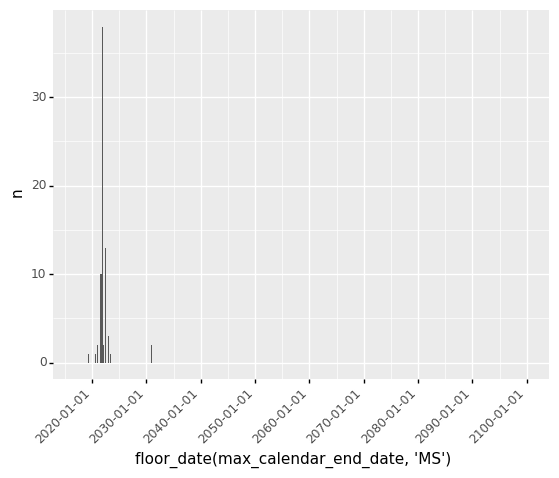

<ggplot: (8778886058247)>

In [81]:
from siuba.experimental.datetime import floor_date

tbl_calendar_max = (
    tbl.gtfs_schedule_type2.calendar_clean()
    >> filter(_.calitp_extracted_at <= "2021-08-01", _.calitp_deleted_at > "2021-08-01")
    >> group_by(_.calitp_itp_id, _.calitp_url_number)
    >> summarize(max_calendar_end_date = _.end_date.max())
)

(tbl_calendar_max
    >> collect()
    >> mutate(max_calendar_end_date = _.max_calendar_end_date.astype("datetime64[ns]"), n = 1)
    >> ggplot(aes("floor_date(max_calendar_end_date, 'MS')", "n" )) + geom_col() + theme(axis_text_x=element_text(angle=45, hjust=1))
)

In [83]:
tbl_end_date_joined = tbl_daily_feeds_enriched >> filter(_.date == "2021-08-01") >> inner_join(_, tbl_calendar_max, ["calitp_itp_id", "calitp_url_number"])

In [92]:
tbl_end_date_filtered = (
    tbl_end_date_joined 
    >> filter(_.feed_end_date.isna()) 
    >> collect() >> arrange(_.max_calendar_end_date) 
    >> select(_.calitp_feed_name, _.max_calendar_end_date)
)

In [97]:
tbl_end_date_filtered.to_csv('calitp_max_calendar_end_date.csv')